In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import random
import pylab as pl
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import optimize
import time
import re
import datetime as dt
import seaborn as sns

from magicloop import *
from pipeline import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


<h2> TASK 1 </h2>

In [3]:
# reading the datasets
credit = read_file('credit-data.csv')

In [4]:
# convert CamelCase columns to snake_case
credit.columns = colname_to_snake(credit)

In [5]:
# credit columns after snake_case conversion 
credit.columns

Index(['person_id', 'serious_dlqin2yrs',
       'revolving_utilization_of_unsecured_lines', 'age', 'zipcode',
       'number_of_time30-59_days_past_due_not_worse', 'debt_ratio',
       'monthly_income', 'number_of_open_credit_lines_and_loans',
       'number_of_times90_days_late', 'number_real_estate_loans_or_lines',
       'number_of_time60-89_days_past_due_not_worse', 'number_of_dependents'],
      dtype='object')

In [6]:
# initial credit df
credit.head(10)

,person_id,serious_dlqin2yrs,revolving_utilization_of_unsecured_lines,age,zipcode,number_of_time30-59_days_past_due_not_worse,debt_ratio,monthly_income,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
0,1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,60629,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,60637,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,60625,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,60804,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,60629,0,0.606291,23684.0,9,0,4,0,2.0


<h2> TASK 2 </h2>

In [8]:
# definining variable
credit_vardict = {'continuous_var' : ['revolving_utilization_of_unsecured_lines', 'age', 'debt_ratio', 'monthly_income'],
            'num_categorical_var' : ['number_of_time30-59_days_past_due_not_worse',
                                     'number_of_open_credit_lines_and_loans', 'number_of_times90_days_late', 
                                     'number_real_estate_loans_or_lines', 'number_of_time60-89_days_past_due_not_worse', 
                                     'number_of_dependents'],
            'categorical_var' : ['zipcode'],
            'dependent_var' : ['serious_dlqin2yrs'],
            'key' : ['person_id']}

cont_var = credit_vardict['continuous_var']
num_cat_var = credit_vardict['num_categorical_var']
cat_var = credit_vardict['categorical_var']

key = credit_vardict['key']
dpn_var = credit_vardict['dependent_var']

num_var = cont_var + num_cat_var
features = num_var + cat_var

In [9]:
num_feature_summary(credit, num_var)

,revolving_utilization_of_unsecured_lines,age,debt_ratio,monthly_income,number_of_time30-59_days_past_due_not_worse,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
count,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,6.048438,52.295207,353.005076,6.670221e+03,0.421033,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,2037.818523,1.438467e+04,4.192781,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.175074,3.400000e+03,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.366508,5.400000e+03,0.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.868254,8.249000e+03,0.000000,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,329664.000000,3.008750e+06,98.000000,58.000000,98.000000,54.000000,98.000000,20.000000


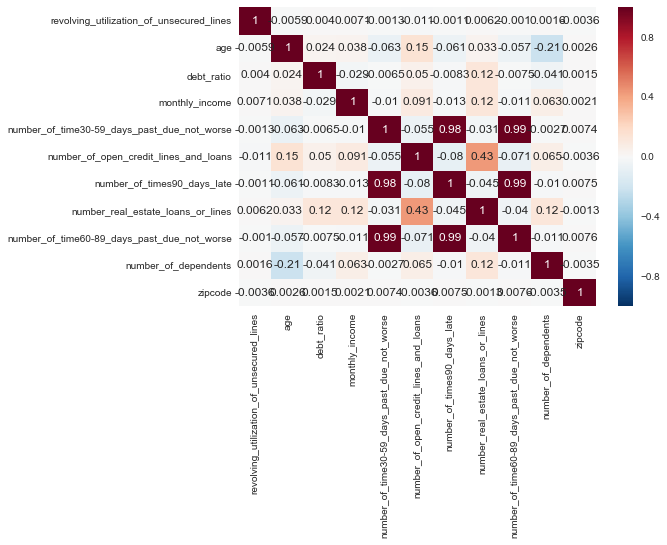

In [10]:
feature_corr(credit, features, notebook = 1)

In [11]:
count_null_by(credit, num_var, 'zipcode')

,revolving_utilization_of_unsecured_lines,age,debt_ratio,monthly_income,number_of_time30-59_days_past_due_not_worse,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
zipcode,,,,,,,,,,
60601,NaN,NaN,NaN,3265,NaN,NaN,NaN,NaN,NaN,438
60618,NaN,NaN,NaN,3229,NaN,NaN,NaN,NaN,NaN,412
60625,NaN,NaN,NaN,6588,NaN,NaN,NaN,NaN,NaN,894
60629,NaN,NaN,NaN,3360,NaN,NaN,NaN,NaN,NaN,439
60637,NaN,NaN,NaN,3328,NaN,NaN,NaN,NaN,NaN,437
60644,NaN,NaN,NaN,3216,NaN,NaN,NaN,NaN,NaN,413
60657,NaN,NaN,NaN,3336,NaN,NaN,NaN,NaN,NaN,460
60804,NaN,NaN,NaN,3409,NaN,NaN,NaN,NaN,NaN,431


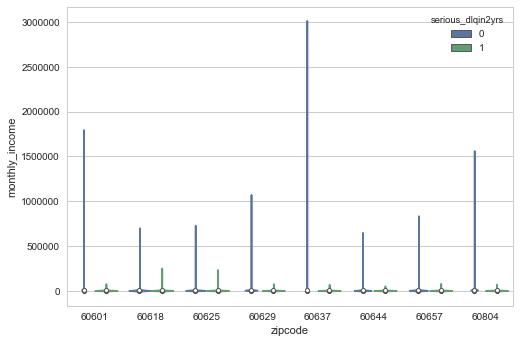

In [12]:
# plotting monthly income distribution by zipcode, separated by deliquency  
sns.set_style("whitegrid")
sns.violinplot(x="zipcode", y="monthly_income", hue='serious_dlqin2yrs', data=credit)

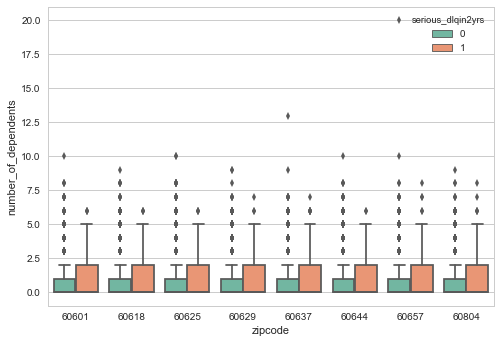

In [13]:
# plotting number of dependents distribution by zipcode, separated by deliquency  
sns.boxplot(x="zipcode", y="number_of_dependents", hue='serious_dlqin2yrs', 
            palette ="Set2",data=credit)

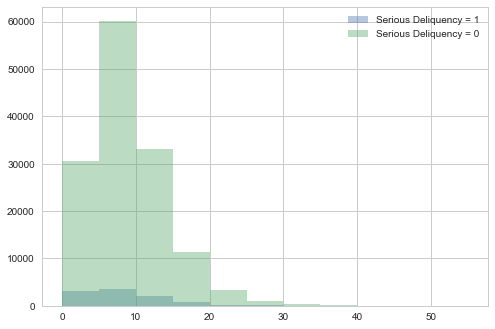

In [14]:
# plotting number of open credit lines and loans distribution, separated by deliquency 
x = credit.loc[credit['serious_dlqin2yrs'] == 1, ['number_of_open_credit_lines_and_loans']]
y = credit.loc[credit['serious_dlqin2yrs'] == 0, ['number_of_open_credit_lines_and_loans']]

sns.distplot(x, kde= False, label= "Serious Deliquency = 1", bins = range(0, 60, 5))
sns.distplot(y, kde= False, label= "Serious Deliquency = 0", bins = range(0, 60, 5))
plt.legend();

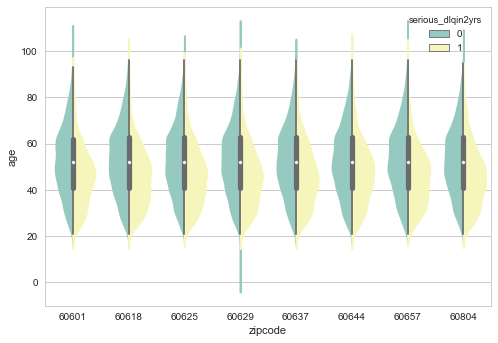

In [15]:
# plotting age distribution by zipcode, separated by deliquency 
sns.violinplot(x="zipcode", y="age", hue='serious_dlqin2yrs', 
            palette ="Set3",data=credit, split = True)

<h2> TASK 3 </h2>

In [17]:
credit = preprocess_data(credit, credit_vardict, group_by = 'zipcode')

In [18]:
credit[:10]

,person_id,serious_dlqin2yrs,revolving_utilization_of_unsecured_lines,age,zipcode,number_of_time30-59_days_past_due_not_worse,debt_ratio,monthly_income,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
0,1,1,0.766127,45,60644,2,0.802982,9120.000000,13,0,6,0,2.0
1,2,0,0.957151,40,60637,0,0.121876,2600.000000,4,0,0,0,1.0
2,3,0,0.658180,38,60601,1,0.085113,3042.000000,2,1,0,0,0.0
3,4,0,0.233810,30,60601,0,0.036050,3300.000000,5,0,0,0,0.0
4,5,0,0.907239,49,60625,1,0.024926,63588.000000,7,0,1,0,0.0
5,6,0,0.213179,74,60629,0,0.375607,3500.000000,3,0,1,0,1.0
6,7,0,0.305682,57,60637,0,5710.000000,6805.487779,8,0,3,0,0.0
7,8,0,0.754464,39,60625,0,0.209940,3500.000000,8,0,0,0,0.0
8,9,0,0.116951,27,60804,0,46.000000,6764.866399,2,0,0,0,0.0
9,10,0,0.189169,57,60629,0,0.606291,23684.000000,9,0,4,0,2.0


<h2>TASK 4</h2>

In [20]:
# dicretizing criteria
credit_bindict = {
        'monthly_income':{'bins': [-1, 2500, 4500, 8500, 30000, 3500000],
                          'group_names': ['LowIncome', 'Low-MiddleIncome', 'MiddleIncome', 'Upper-MiddleIncome','HighIncome']},
        'number_of_dependents':{'bins': [0, 0, 3, 6, 20],
                                'group_names': ['No Dependency', 'Low Dependency', 'Medium Dependency', 'High Dependency']},
        'age':{'bins':[-1, 20, 30, 40, 50, 60, 70,120],
               'group_names': None}
        }

In [21]:
dicretize_var(credit, 'monthly_income', credit_bindict, new_colname = 'income_bucket', inplace = True)

In [22]:
dummy_var(credit, 'income_bucket', inplace = True)

In [23]:
credit.head()

,person_id,serious_dlqin2yrs,revolving_utilization_of_unsecured_lines,age,zipcode,number_of_time30-59_days_past_due_not_worse,debt_ratio,monthly_income,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents,income_bucket
0,1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0,Upper-MiddleIncome
1,2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0,Low-MiddleIncome
2,3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0,Low-MiddleIncome
3,4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0,Low-MiddleIncome
4,5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0,HighIncome


<h2> TASK 5 & 6 </h2>

/Users/rwidjaya/Documents/SPR17 - Machine Learning/ML_repo/HW3/pipeline.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rdf.fit(data[features], data[y])


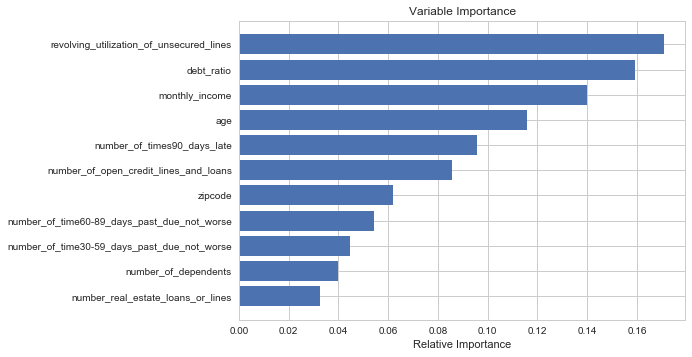

In [25]:
# predicting feature importance using random forest
feature_importance_rf(credit, features, dpn_var, notebook = 1)

<h1> Run Classifiers </h1>

In [ ]:
def main(data):
    grid_size = 'pa3'
    clfs, grid = define_clfs_params(grid_size)
    models_to_run=['RF','DT','KNN', 'AB', 'GB', 'LR', 'BAG']

    features  =  ['revolving_utilization_of_unsecured_lines', 'debt_ratio', 'age', 'number_of_times90_days_late']
    X = data[features]
    y = data.serious_dlqin2yrs
    results_df = clf_loop(models_to_run, clfs,grid, X,y)
    
    results_df.to_csv('results.csv', index=False)
    
    return results_df

RF
parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10}
processing_time: 0.859637975692749


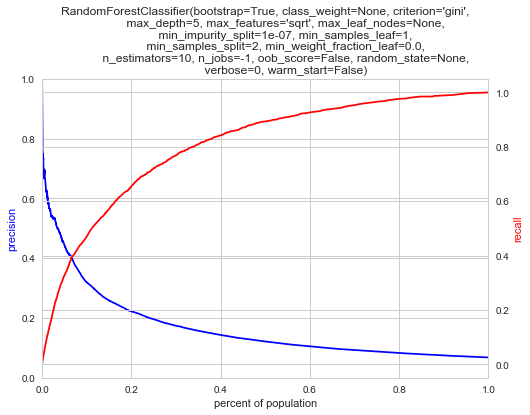

parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
processing_time: 6.843305826187134


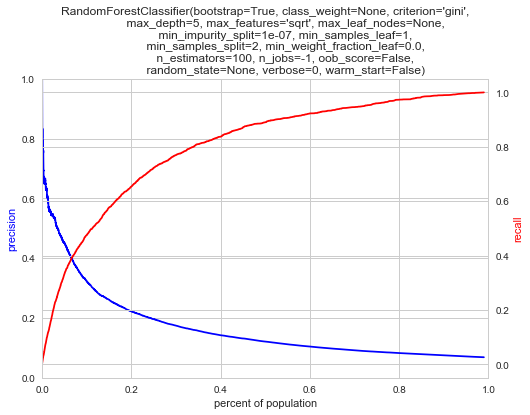

parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10}
processing_time: 0.784966230392456


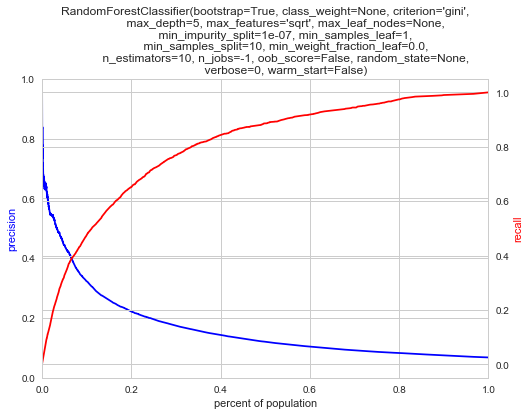

parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
processing_time: 5.825917959213257


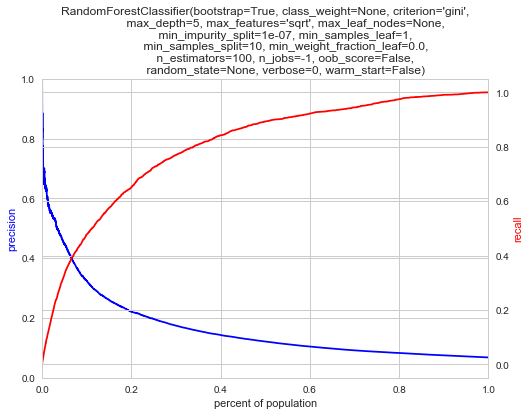

parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10}
processing_time: 0.8679161071777344


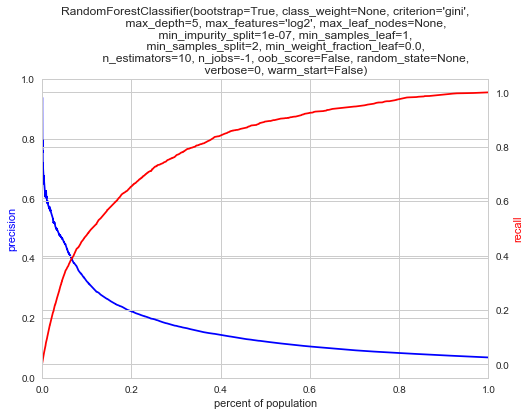

parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
processing_time: 7.128989219665527


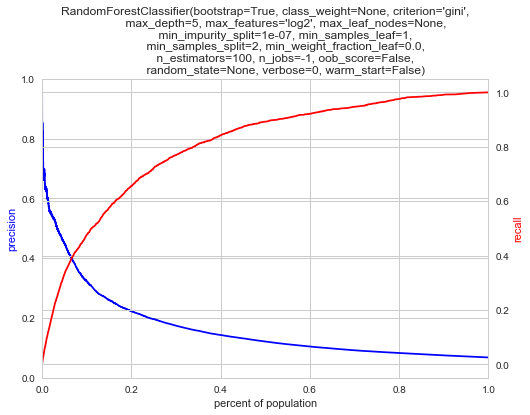

parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10}
processing_time: 0.7550580501556396


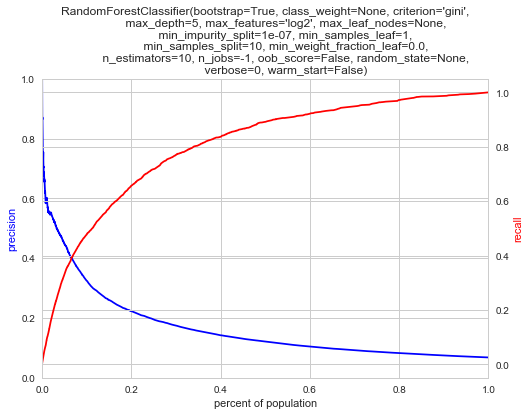

parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}
processing_time: 7.8138933181762695


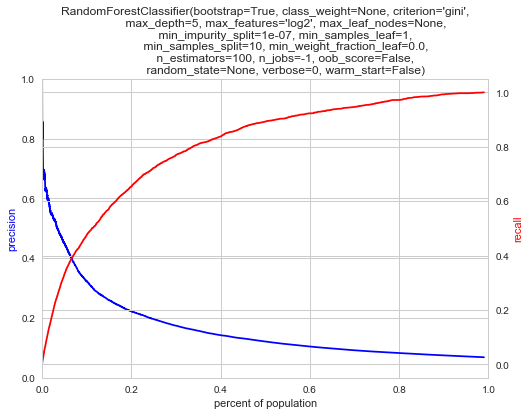

parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10}
processing_time: 1.2767701148986816


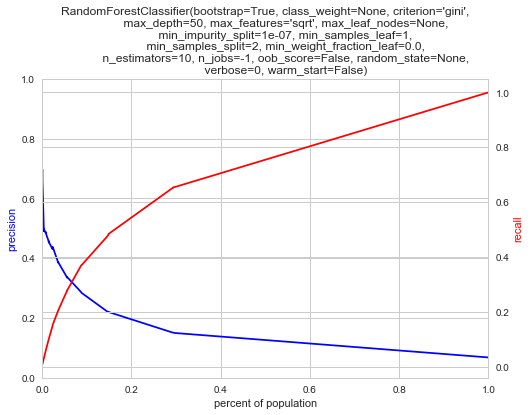

parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
processing_time: 13.798816919326782


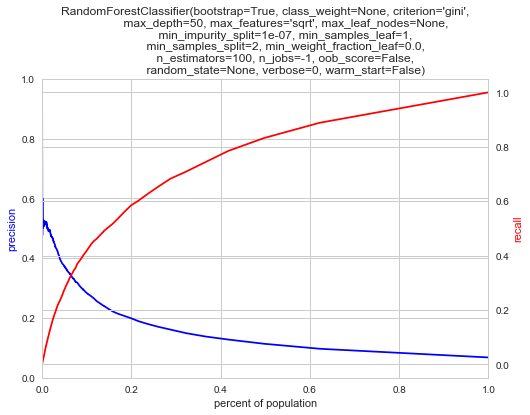

parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10}
processing_time: 2.0055670738220215


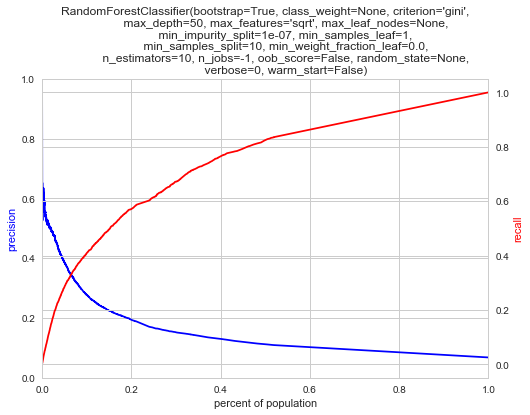

parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
processing_time: 11.639476299285889


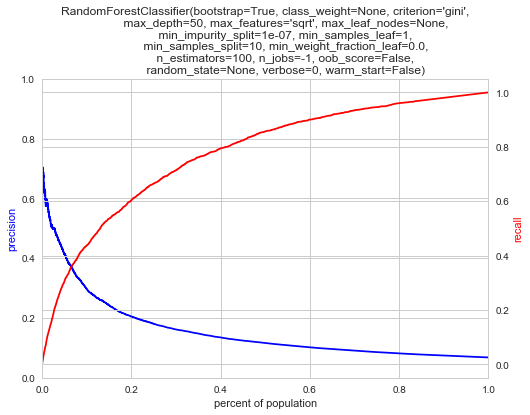

parameters: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10}
processing_time: 1.6963999271392822


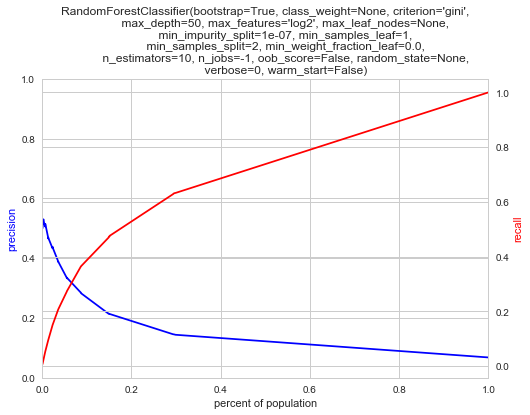

parameters: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
processing_time: 16.923017978668213


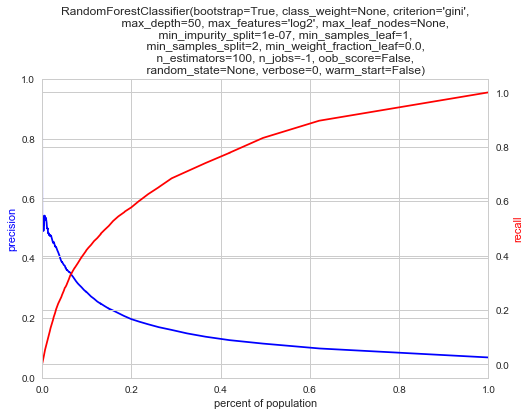

parameters: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10}
processing_time: 1.9201948642730713


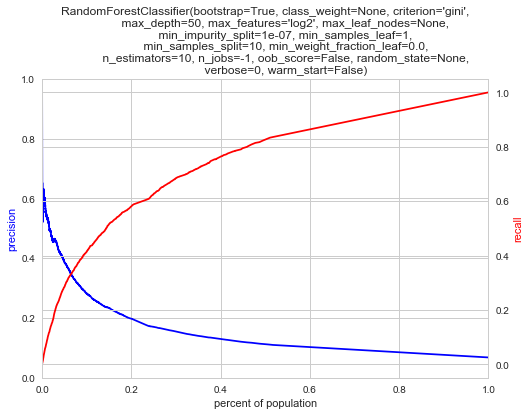

parameters: {'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}
processing_time: 13.89234185218811


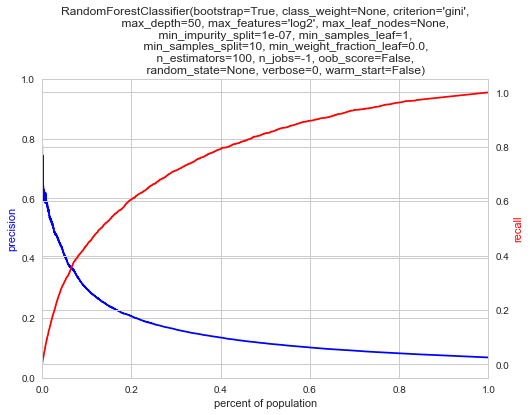

DT
parameters: {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 2}
processing_time: 0.0606989860534668


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


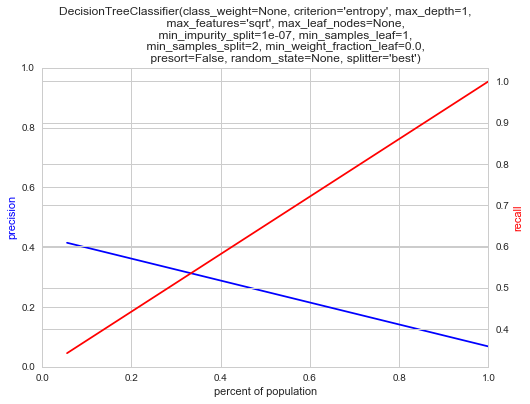

parameters: {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 5}
processing_time: 0.04480600357055664


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


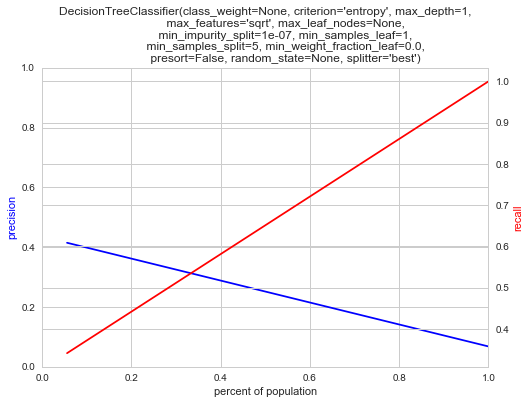

parameters: {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 2}
processing_time: 0.057533979415893555


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


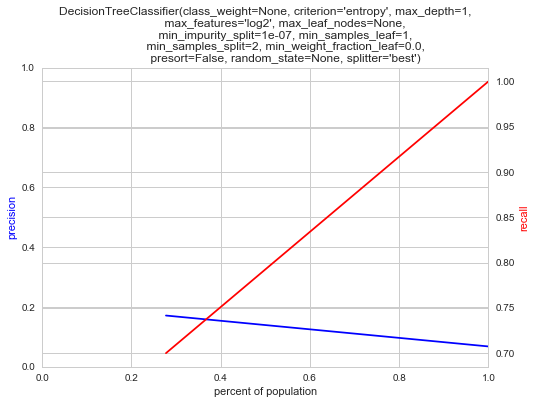

parameters: {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 5}
processing_time: 0.05698728561401367


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


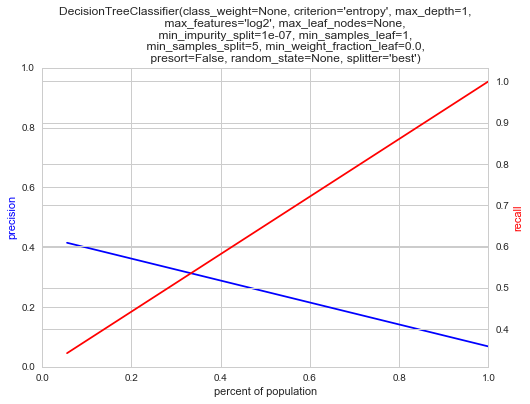

parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2}
processing_time: 0.13468503952026367


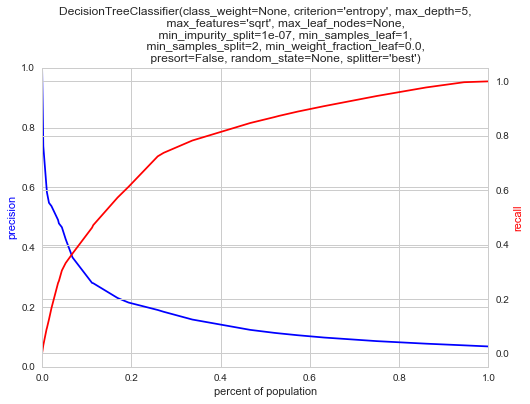

parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5}
processing_time: 0.14042282104492188


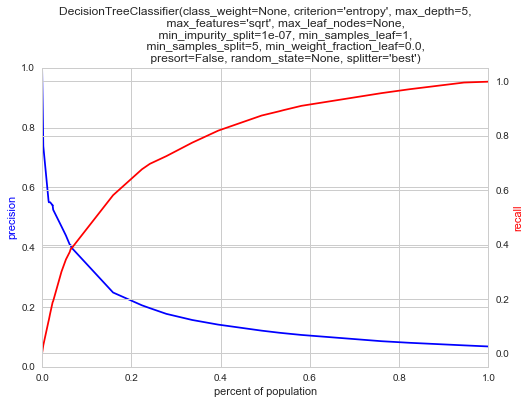

parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2}
processing_time: 0.18597769737243652


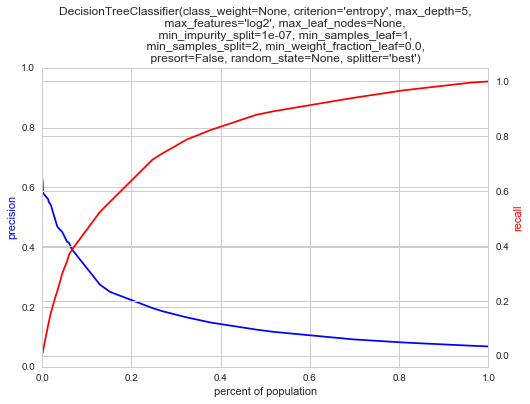

parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5}
processing_time: 0.1468660831451416


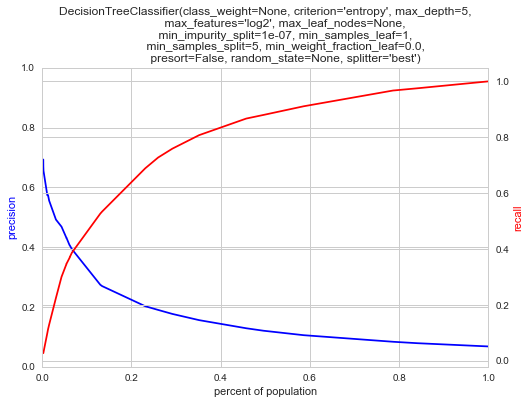

KNN
parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
processing_time: 2.3297648429870605


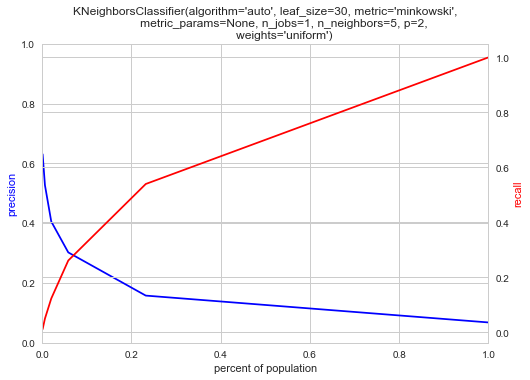

parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
processing_time: 2.6341800689697266


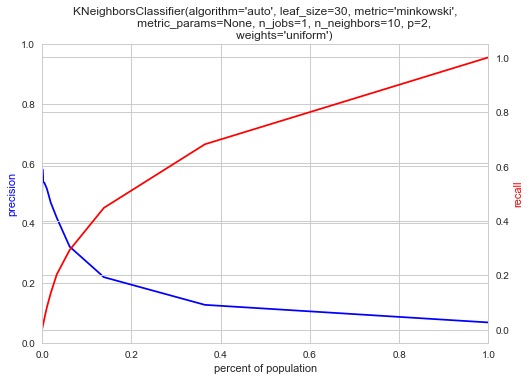

AB
parameters: {'algorithm': 'SAMME', 'n_estimators': 1}
processing_time: 0.13283729553222656


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


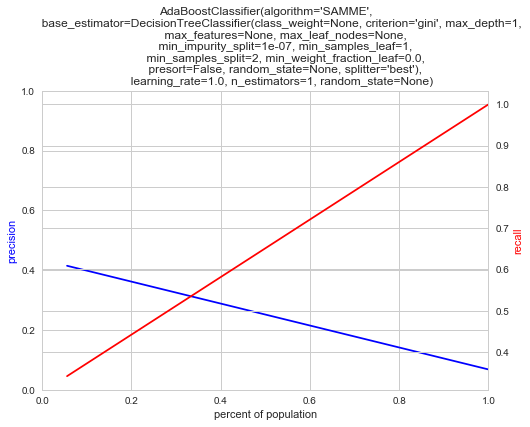

parameters: {'algorithm': 'SAMME', 'n_estimators': 10}
processing_time: 0.6228170394897461


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


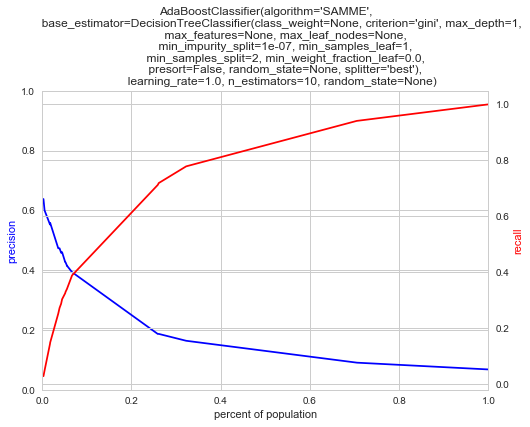

parameters: {'algorithm': 'SAMME.R', 'n_estimators': 1}
processing_time: 0.0927588939666748


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


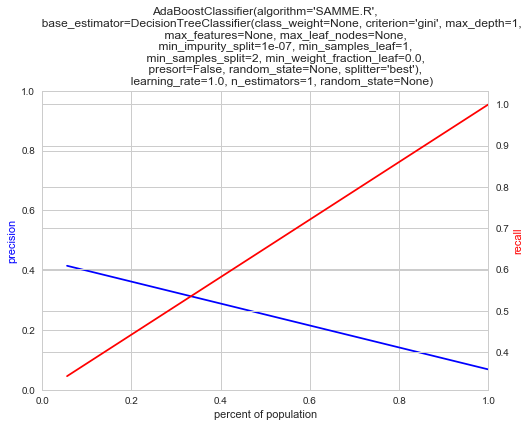

parameters: {'algorithm': 'SAMME.R', 'n_estimators': 10}
processing_time: 0.8199501037597656


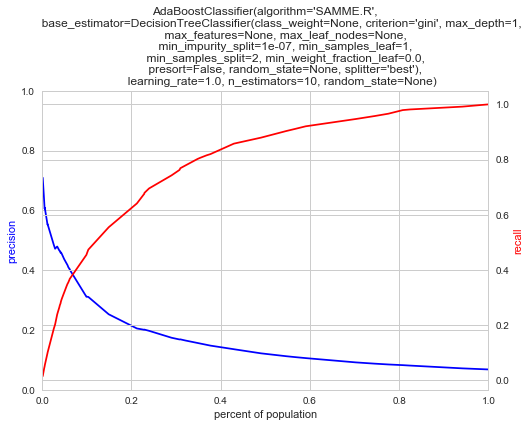

GB
parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1, 'subsample': 0.5}
processing_time: 0.17593693733215332


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


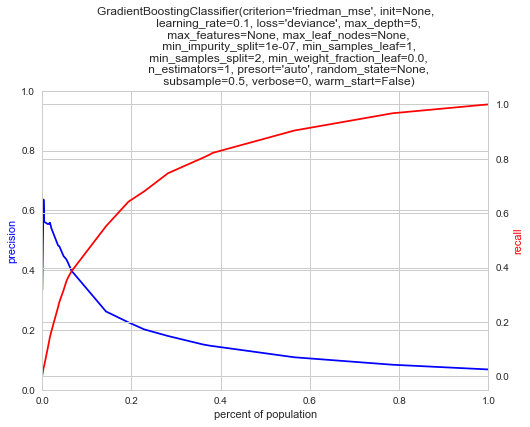

parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1, 'subsample': 1.0}
processing_time: 0.30246782302856445


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


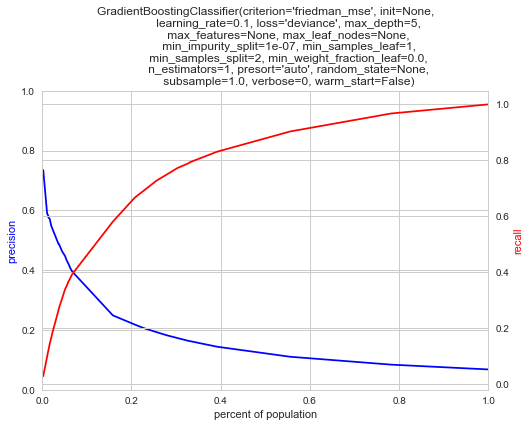

parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.5}
processing_time: 1.3585028648376465


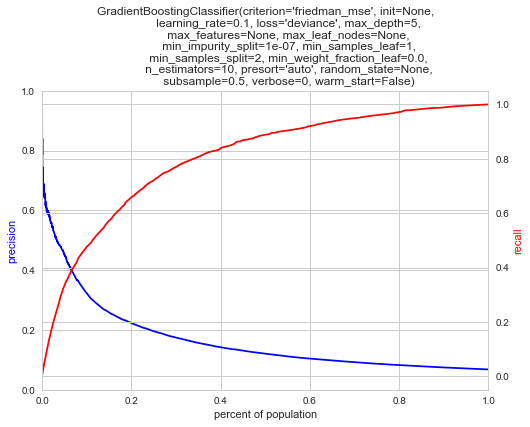

parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10, 'subsample': 1.0}
processing_time: 1.9241530895233154


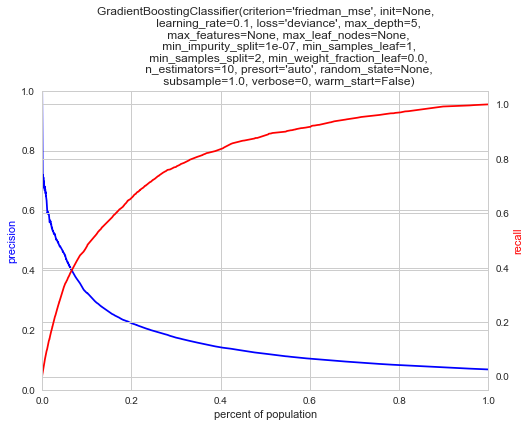

parameters: {'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 1, 'subsample': 0.5}
processing_time: 3.957131862640381


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


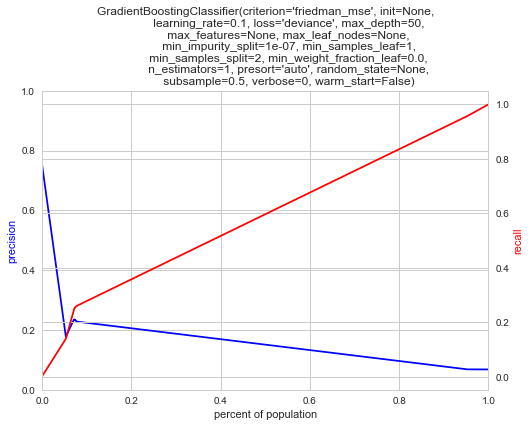

parameters: {'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 1, 'subsample': 1.0}
processing_time: 8.437540054321289


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


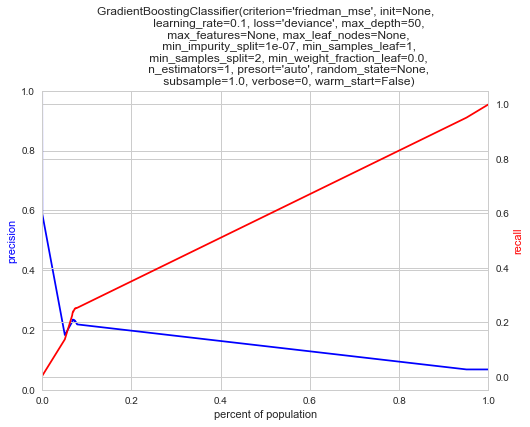

parameters: {'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 10, 'subsample': 0.5}
processing_time: 124.60915493965149


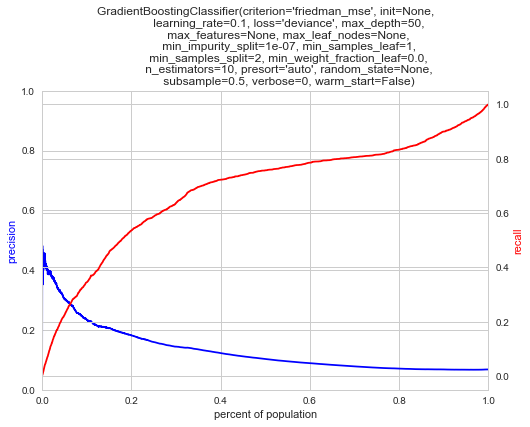

parameters: {'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 10, 'subsample': 1.0}
processing_time: 98.94623112678528


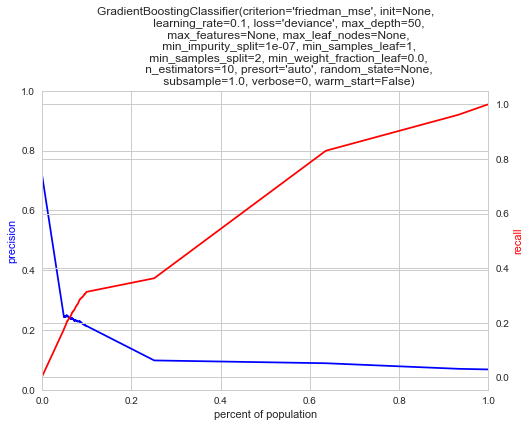

parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 1, 'subsample': 0.5}
processing_time: 0.21299195289611816


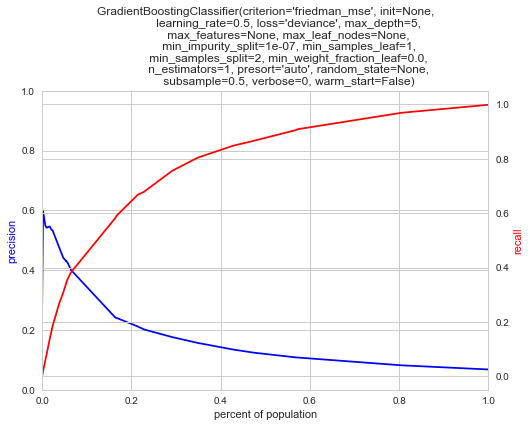

parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 1, 'subsample': 1.0}
processing_time: 0.31809091567993164


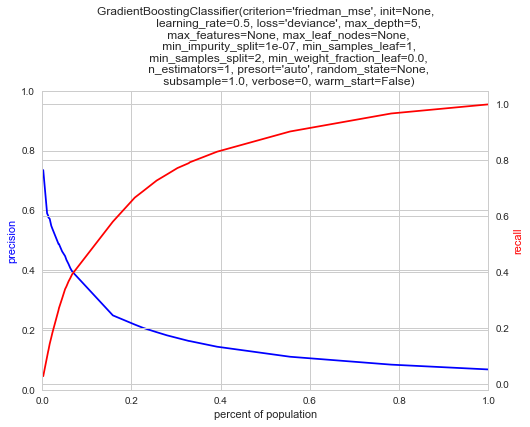

parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.5}
processing_time: 4.703552007675171


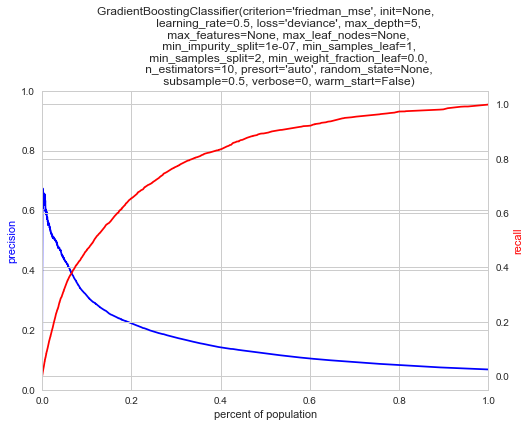

parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10, 'subsample': 1.0}
processing_time: 2.6119911670684814


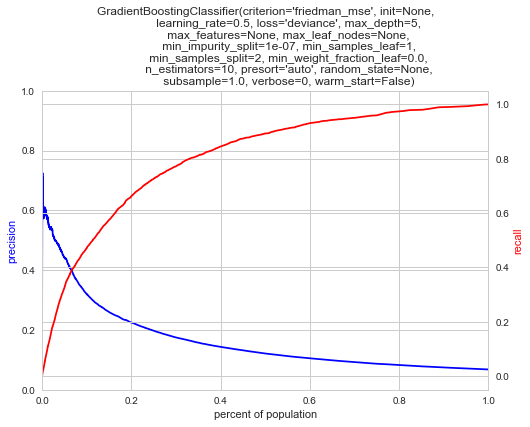

parameters: {'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 1, 'subsample': 0.5}
processing_time: 5.4404542446136475


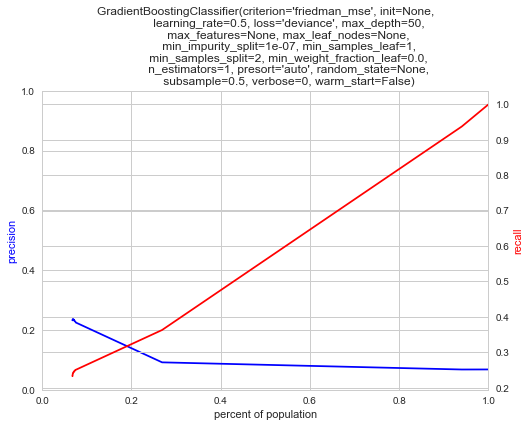

parameters: {'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 1, 'subsample': 1.0}
processing_time: 10.327847242355347


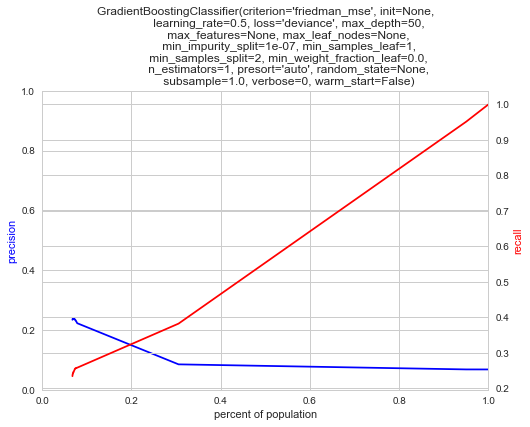

parameters: {'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 10, 'subsample': 0.5}
processing_time: 147.2027771472931


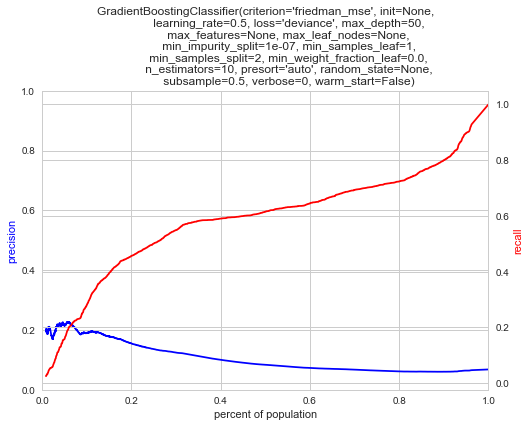

parameters: {'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 10, 'subsample': 1.0}
processing_time: 86.76867318153381


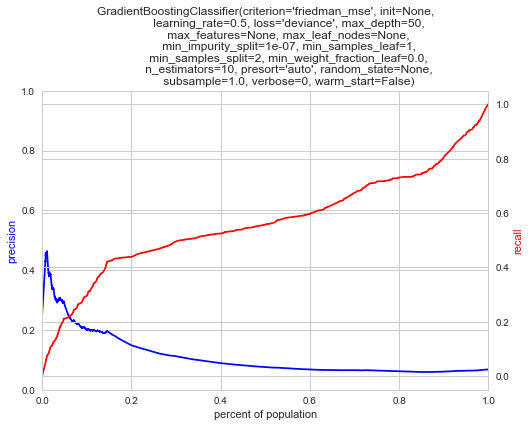

LR
parameters: {'C': 0.1, 'penalty': 'l1'}
processing_time: 0.4412500858306885


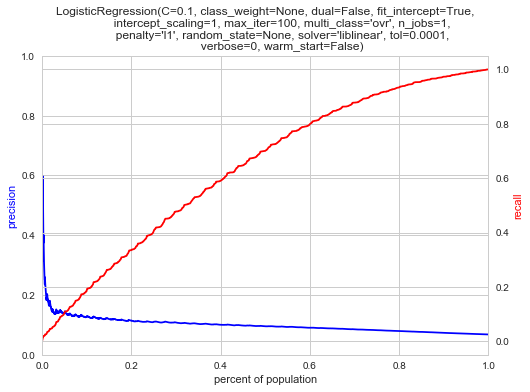

parameters: {'C': 0.1, 'penalty': 'l2'}
processing_time: 0.3271462917327881


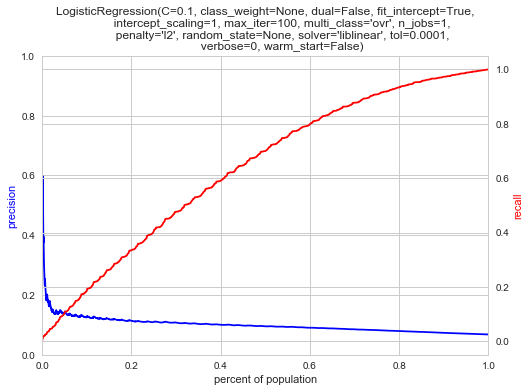

parameters: {'C': 1, 'penalty': 'l1'}
processing_time: 0.32547998428344727


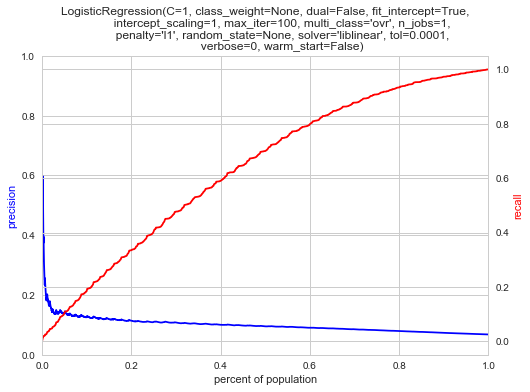

parameters: {'C': 1, 'penalty': 'l2'}
processing_time: 0.3200960159301758


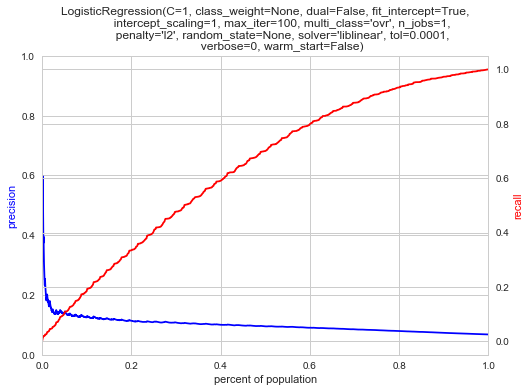

BAG
parameters: {'max_samples': 10, 'n_estimators': 10}
processing_time: 1.0230817794799805


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


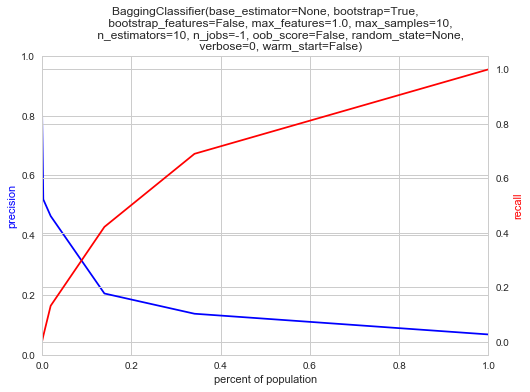

parameters: {'max_samples': 10, 'n_estimators': 100}
processing_time: 1.7058320045471191


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


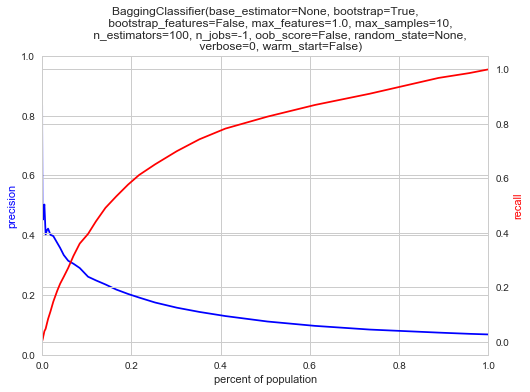

,model_type,clf,parameters,accuracy,f1_score,auc-roc,p_at_5,p_at_10,p_at_20,%time
0,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.934267,0.188344,0.827855,0.448000,0.319200,0.222400,0.859638
1,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.934613,0.193951,0.826046,0.450667,0.322400,0.221867,6.843306
2,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.934453,0.190382,0.825283,0.443733,0.324800,0.221333,0.784966
3,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.934267,0.202007,0.826715,0.448533,0.324267,0.221067,5.825918
4,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.934373,0.220462,0.826816,0.453867,0.323200,0.222133,0.867916
5,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.934453,0.202983,0.827089,0.450133,0.323200,0.222533,7.128989
6,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.933680,0.190166,0.825925,0.448000,0.324533,0.223333,0.755058
7,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'max_features': 'log2', 'min_...",0.934827,0.202870,0.826937,0.449600,0.322933,0.222000,7.813893
8,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.929013,0.227958,0.726552,0.373867,0.324267,0.220933,1.276770
9,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 50, 'max_features': 'sqrt', 'min...",0.930240,0.247411,0.774074,0.373333,0.287467,0.201067,13.798817


In [28]:
main(credit)

<strong>REPORT:</strong>
</br>
Decision Tree appears to be the classifier method that perform the best out of other selected methods (Random Forest, K-Nearest Neighbor, Bagging, Log Regression, Gradient Boosting, and Ada Boosting) with around 0.045 sec. runtime and 0.93 accuracy score. The model is currenly only using a small subset of the available features, hence the limited success reflected in the evaluation metrics. Further study should be focused on fitting and fine-tuning the model to include more relevant features.  